# G only KEGG based network architecture

> 

In [75]:
import numpy as np
import pandas as pd

from EnvDL.core import ensure_dir_path_exists 
from EnvDL.dlfn import g2fc_datawrapper, BigDataset, plDNN_general
from EnvDL.dlfn import ResNet2d, BasicBlock2d
from EnvDL.dlfn import LSUV_

import torch
import torch.nn.functional as F # F.mse_loss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger

In [76]:
from tqdm import tqdm
from graphviz import Digraph

In [77]:
# Run settings: 
max_epoch = 2
batch_size = 24

In [78]:
use_gpu_num = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
if use_gpu_num in [0, 1]: 
    torch.cuda.set_device(use_gpu_num)
print(f"Using {device} device")

Using cuda device


In [79]:
cache_path = '../nbs_artifacts/02.31_g2fc_G_ACGT_VNN__scratchpad/'
ensure_dir_path_exists(dir_path = cache_path)

In [80]:
# Settings:
run_baseline = False
run_alternate = True

## Demonstration Version

New classes to help prepare network.

In [81]:
# Drawing on example version 

n_obs = 100 # 100 obs for each group
y_true = torch.from_numpy(np.concatenate([
        np.zeros((n_obs, )),
        np.ones( (n_obs, ))], 0)) + .1* torch.rand(2*n_obs,)

input_tensor_dict = {
    'in1': torch.from_numpy(np.concatenate([
        np.zeros((n_obs, 4, 3)),
        np.ones( (n_obs, 4, 3))], 0)),
    'in2': torch.from_numpy(np.concatenate([
        np.zeros((n_obs, 4, 2)),  
        np.ones( (n_obs, 4, 2))], 0))}

x_list_temp = [input_tensor_dict[key].to(torch.float) for key in input_tensor_dict.keys()]
[e.shape for e in x_list_temp]

[torch.Size([200, 4, 3]), torch.Size([200, 4, 2])]

In [82]:
kegg_connections = {
    'y_hat':['d', 'c'],
    'd':['b'],
    'c':['a'],
    'b':['in2', 'a'],
    'a':['in1'],
    'in1': [],
    'in2': []
}

In [83]:
class VNNHelper():
    def __init__(self, edge_dict, all_values_are_nodes = True) -> None:
        self.edge_dict = edge_dict.copy()
        # handles updating all the lists of node groups (imp, out, edge)
        self._setup_wrapper(all_values_are_nodes)

        self.node_props = {}
        for e in self.node_keys_vals['all_keys']:
            self.node_props[e] = {}

    def _setup_wrapper(self, all_values_are_nodes):
        if all_values_are_nodes:
            self._init_missing_nodes_as_input()
        self.node_keys_vals = self._find_uniq_keys_values(input_dict = self.edge_dict)
        self.nodes_inp = self._find_nodes_inp(all_key_value_dict = self.node_keys_vals)
        self.nodes_out = self._find_top_nodes(all_key_value_dict = self.node_keys_vals)
        self.nodes_edge= self._find_nodes_edge(all_key_value_dict= self.node_keys_vals, nodes_inp= self.nodes_inp, nodes_out = self.nodes_out)
        # sets self.dependancy_order
        self._get_run_order()

    # CRUD operations on node proprty dictionary
    def node_prop_create(self, name):
        self.node_props[name] = {}
        
    def node_prop_read_keys(self, name):
        return self.node_props[name].keys()

    def node_prop_read_values(self, name, key):
        return self.node_props[name][key]

    def node_prop_update(self, name, key, value):
        self.node_props[name][key] = value

    def node_prop_delete(self, name, key=None):
        if key == None:
            del self.node_props[name]
        else:
            del self.node_props[name][key]


    def _find_uniq_keys_values(self, input_dict):
        """
        Building a Neural Net from an arbitrary graph
        start by finding the top level -- all those keys which are theselves not values
        helper function to get all keys and all value from a dict. Useful for when keys don't have unique values.
        """
        all_keys = list(input_dict.keys())
        all_values = []
        for e in all_keys:
            all_values.extend(input_dict[e])
        all_values = list(set(all_values))

        return({'all_keys': all_keys, 'all_values': all_values})

    def _find_top_nodes(self, all_key_value_dict):
        """
        Find order that nodes in the graph should be called to have all dependencies run when they are called.
        find the dependancies for run order from many dependancies to none
        wrapper function to find the nodes that aren't any other nodes dependancies.
        """
        return([e for e in all_key_value_dict['all_keys'] if e not in all_key_value_dict['all_values']])
    
    def _init_missing_nodes_as_input(self):
        node_keys_vals = self._find_uniq_keys_values(input_dict = self.edge_dict)
        add_these_nodes = [e for e in node_keys_vals['all_values'] if e not in node_keys_vals['all_keys']]
        for e in add_these_nodes:
            self.edge_dict[e] = []

    def _find_nodes_inp(self, all_key_value_dict):
        # """
        # wrapper function to find the input nodes. They don't occur in the keys and thus won't be added to the list otherwise.
        # another way to do this would have been to 
        # """
        # return([e for e in all_key_value_dict['all_values'] if e not in all_key_value_dict['all_keys']])
        return [e for e in all_key_value_dict['all_keys'] if self.edge_dict[e] == []]

    def _find_nodes_edge(self, all_key_value_dict, nodes_inp, nodes_out):
        return [e for e in all_key_value_dict['all_keys'] if e not in nodes_inp+nodes_out]

    def append_output_node(self, node_name):
        if node_name in self.edge_dict.keys():
            pass
        else:
            self.edge_dict[node_name] = self.nodes_out
            self._setup_wrapper()
            self.node_prop_create(name = node_name)

    def _get_run_order(self, max_iter = 1000):
        temp = self.edge_dict.copy()
        dependancy_order = []
        # Then iterate
        for _ in range(max_iter): 
            top_nodes = self._find_top_nodes(all_key_value_dict = self._find_uniq_keys_values(input_dict = temp))
            if top_nodes == []:
                break
            else:
                dependancy_order += top_nodes    
                # remove nodes from the graph that are at the 'top' level and haven't already been removed
                for key in [e for e in dependancy_order if e in temp.keys()]:
                    temp.pop(key)

        # reverse to get the order that the nodes should be called
        dependancy_order.reverse()                
        self.dependancy_order = dependancy_order


    def set_node_props(self, key, node_val_dict):
        for name, val in node_val_dict:
            self.node_prop_update(name = name, key=key, value=val)
    
    def calc_edge_inp(self):
        for name in self.nodes_edge + self.nodes_out: 
            inp_size = sum([self.node_prop_read_values(name = e, key= 'out') for e in self.edge_dict[name]])
            self.node_prop_update(name = name, key='inp', value=inp_size)     

    def mk_digraph(self, include = ['node_name', 'inp_size', 'out_size']):
        dot = ''
        dot = Digraph()
        for key in self.node_props.keys():
            key_label = []

            if 'node_name' in include: key_label += [key]
            if 'inp_size' in include: key_label += ['In  '+str(self.node_props[key]['inp'])]
            if 'out_size' in include: key_label += ['Out '+str(self.node_props[key]['out'])]
            
            if len(key_label) == 0:
                key_label = ''
            else:
                key_label = '\n'.join(key_label)

            dot.node(key, key_label)
            for value in self.edge_dict[key]:
                # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
                dot.edge(value, key)    
        return dot
    

myvnn = VNNHelper(edge_dict = kegg_connections)

myvnn.nodes_inp[0:10]



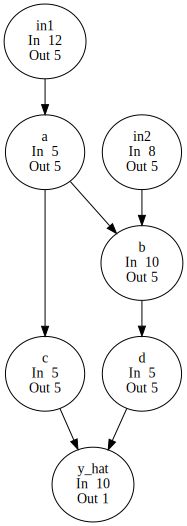

In [84]:
myvnn = VNNHelper(edge_dict = kegg_connections)

# init input node sizes
inp_tensor_name_to_size = zip(
    ['in1', 'in2'], 
    [int(torch.prod(torch.tensor(e.shape)[1:])) for e in x_list_temp])

myvnn.set_node_props(key = 'inp', node_val_dict = inp_tensor_name_to_size)

# init node output sizes
myvnn.set_node_props(key = 'out', node_val_dict = zip(myvnn.nodes_inp, [5 for e in myvnn.nodes_inp]))
myvnn.set_node_props(key = 'out', node_val_dict = zip(myvnn.nodes_edge,[5 for e in myvnn.nodes_edge]))
myvnn.set_node_props(key = 'out', node_val_dict = zip(myvnn.nodes_out, [1 for e in myvnn.nodes_out]))


# options should be controlled by node_props
myvnn.set_node_props(key = 'flatten', node_val_dict = zip(
    myvnn.nodes_inp, 
    [True for e in myvnn.nodes_inp]))

myvnn.set_node_props(key = 'reps', node_val_dict = zip(
    myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge, 
    [1 for e in myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge]))

# init dropout 
myvnn.set_node_props(key = 'drop', node_val_dict = zip(
    myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge, 
    [0.0 for e in myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge]))

# init edge node input size (propagate forward input/edge outpus)
myvnn.calc_edge_inp()

myvnn.mk_digraph(include = ['node_name', 'inp_size', 'out_size'])

In [85]:
def Linear_block(in_size, out_size, drop_pr, block_reps):
    block_list = []
    for i in range(block_reps):
        if i == 0:
            block_list += [
                nn.Linear(in_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr)]
        else:
            block_list += [
                nn.Linear(out_size, out_size),
                nn.ReLU(),
                nn.Dropout(drop_pr)]

    block = nn.ModuleList(block_list)
    return(block)     

In [86]:
class VisableNeuralNetwork(nn.Module):
    def __init__(self, 
                 node_props, 
                 Linear_block,
                 dependancy_order,
                 edge_dict,
                 node_to_inp_num_dict
                ):
        super(VisableNeuralNetwork, self).__init__()
        # Store nodes in dict
        layer_dict = {}
        for key in node_props.keys():
            node_list = []
            if 'flatten' in node_props[key]:
                node_list += [nn.Flatten()]
            node_list += [nn.Flatten()]
            #TODO change linear block instead of conditioning on node name.
            if key != 'y_hat':
                node_list += [Linear_block(
                    in_size=node_props[key]['inp'], 
                    out_size=node_props[key]['out'], 
                    drop_pr=node_props[key]['drop'],
                    block_reps=node_props[key]['reps'])]
            else:
                node_list += [nn.Linear(node_props[key]['inp'], node_props[key]['out'])]

            layer_dict[key] = nn.ModuleList(node_list)

        self.layer_dict = nn.ModuleDict(layer_dict)
        
        self.dependancy_order = dependancy_order
        self.edge_dict = edge_dict
        self.node_to_inp_num_dict = node_to_inp_num_dict

    def forward(self, x):
        temp_res_dict = {}
        for key in self.dependancy_order:
            
            # if the node depends on raw inputs, get them.
            if key in self.node_to_inp_num_dict:
                xin = [ x[self.node_to_inp_num_dict[key]] ]

            # if the node depends on inputs that have been stored in the lookup dict
            if self.edge_dict[key] != []:
                if xin == None:
                    xin = []
                xin += [temp_res_dict[e] for e in self.edge_dict[key]]
                
            # join all input tensors.
            xin = torch.concat(xin, axis = 1)

            for l in self.layer_dict[key]:
                if type(l) == torch.nn.modules.container.ModuleList:
                    for ll in l:            
                        xin = ll(xin)
                else:
                    xin = l(xin)
                    
            temp_res_dict[key] = xin
            xin = None 
        return temp_res_dict[self.dependancy_order[-1]]

In [87]:
model = VisableNeuralNetwork(
    node_props = myvnn.node_props,
    Linear_block = Linear_block,
    edge_dict = myvnn.edge_dict,
    dependancy_order = myvnn.dependancy_order,
    node_to_inp_num_dict = {'in1': 0, 'in2': 1}
)
model(x_list_temp)[0:5]
# model.layer_dict

tensor([[0.4001],
        [0.4001],
        [0.4001],
        [0.4001],
        [0.4001]], grad_fn=<SliceBackward0>)

## Functions

## Load data

In [88]:
# X = g2fc_datawrapper()
# X.set_split()
# X.load_all(name_list = ['obs_geno_lookup', 'YMat', 'KEGG_slices',], store=True) 

# X.calc_cs('YMat', version = 'np', filter = 'val:train')


# ACGT_gene_slice_list = X.get('KEGG_slices',     ops_string='')

## Generate Graph for DNN (Refactored Original)

### Functions to process KEGG entries into a graph.

In [89]:
## Building a Neural Net from an arbitrary graph
# start by finding the top level -- all those keys which are theselves not values
# helper function to get all keys and all value from a dict. Useful for when keys don't have unique values.
def find_uniq_keys_values(input_dict):
    all_keys = list(input_dict.keys())
    all_values = []
    for e in all_keys:
        all_values.extend(input_dict[e])
    all_values = list(set(all_values))

    return({'all_keys': all_keys,
           'all_values': all_values})
           

In [90]:
### Find order that nodes in the graph should be called to have all dependencies run when they are called.
# find the dependancies for run order from many dependancies to none
# wrapper function to find the nodes that aren't any other nodes dependancies.
def find_top_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_keys'] if e not in all_key_value_dict['all_values']])
# wrapper function to find the input nodes. They don't occur in the keys and thus won't be added to the list otherwise.
# another way to do this would have been to 
def find_input_nodes(all_key_value_dict):
    return([e for e in all_key_value_dict['all_values'] if e not in all_key_value_dict['all_keys']])

In [91]:
# LOD is list of dicts.
# def kegg_brite_LOD_to_connections(
def kegg_connections_build(
        n_genes, 
        kegg_gene_brite):
    """
    The goal here is to have a dict with each node and a list of it's children. 
    For example, the graph
    a--b--d
    |-c--e
    Would be parsed into     
    {'a':['b', 'c'],
    'b':['d'],
    'c':['e']}
    """
    kegg_connections = {}
    # for all genes in list
    for i in tqdm(range(n_genes)): 
        temp = kegg_gene_brite[i]['BRITE']['BRITE_PATHS']
        # clean up to make sure that there are no ":" characters. These can mess up graphviz
        temp = [[temp[j][i].replace(':', '-') for i in range(len(temp[j])) ] for j in range(len(temp))]
        # all paths through graph associated with a gene
        for j in range(len(temp)):
            # steps of the path through the graph
            for k in range(len(temp[j])-1):
                
                # name standardization 
                temp_jk  = temp[j][k]
                temp_jk1 = temp[j][k+1]
                temp_jk  = temp_jk.lower().title().replace(' ', '')
                temp_jk1 = temp_jk1.lower().title().replace(' ', '')
                
                # if this is a new key, add it and add the k+1 entry as it's child
                if temp_jk  not in kegg_connections.keys():
                    kegg_connections[temp_jk] = [temp_jk1]
                else: 
                    # Check to see if there's a new child to add   
                    if temp_jk1 not in kegg_connections[temp_jk]:
                        # make sure that no key contains itself. This was a problem for 'Others' which is now disallowed.
                        if (temp_jk != temp_jk1):
                            # add it.
                            kegg_connections[temp_jk].extend([temp_jk1])
    return(kegg_connections)          


In [92]:
def kegg_connections_clean(kegg_connections):
    if 'Others' in kegg_connections.keys():
        del kegg_connections['Others']
        print('Removed node "Others"')

    # remove 'Others' as a possible value
    for key in kegg_connections.keys():
        kegg_connections[key] = [e for e in kegg_connections[key] if e != 'Others']

    # Make sure that no list contains it's own key
    for key in kegg_connections.keys():
        kegg_connections[key] = [e for e in kegg_connections[key] if e != key]

    # there might be associations with no dependants and with no dependants except those that have no dependants.
    # Build up a list with those keys that don't connect back to snps then I'll pass over the connection dict once to remove references to them.
    rm_list = []
    rm_list_i = len(rm_list)
    rm_list_j = -1
    for i in range(100):
        if rm_list_i == rm_list_j:
            break
        else:
            rm_list = [key for key in kegg_connections.keys() if [e for e in kegg_connections[key] if e not in rm_list] == []]
            rm_list_j = rm_list_i 
            rm_list_i = len(rm_list)
    # rm_list

    for key in rm_list:
        del kegg_connections[key]
        
    for key in kegg_connections.keys():
        kegg_connections[key] = [e for e in kegg_connections[key] if e not in rm_list]
    return kegg_connections

In [93]:
def kegg_connections_append_y_hat(kegg_connections):
    # add yhat node to the graph
    temp_values = []
    for key in kegg_connections.keys():
        temp_values += kegg_connections[key]

    kegg_connections['y_hat'] = [key for key in kegg_connections.keys() if key not in temp_values]
    return kegg_connections

In [94]:
def kegg_connections_digraph(kegg_connections, option = ''):
    dot = ''
    if option == '':
        dot = Digraph()
        for key in tqdm(kegg_connections.keys()):
            dot.node(key)
            for value in kegg_connections[key]:
                # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
                dot.edge(value, key)

    if option == 'number':
        name_to_num_dict = dict(zip(list(kegg_connections.keys()),
                                    [str(i) for i in range(len(list(kegg_connections.keys())))]))

        temp = {}
        for key in kegg_connections.keys():
            temp[name_to_num_dict[key]] = [name_to_num_dict[e] if e in name_to_num_dict.keys() else e for e in kegg_connections[key]]

        dot = Digraph()
        for key in tqdm(temp.keys()):
            dot.node(key)
            for value in temp[key]:
                # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
                dot.edge(value, key)                 
                 
    return dot

Version with the node names masked for size 

### Setup to build the graph

In [95]:
def kegg_connections_find_in_out_nodes(kegg_connections):
    # start by finding the top level -- all those keys which are theselves not values
    res = find_uniq_keys_values(input_dict = kegg_connections)
    all_keys = res['all_keys']
    all_values = res['all_values']

    # use the keys to find the input/outputs of the graph
    output_nodes = [e for e in all_keys if e not in all_values]
    input_nodes = [e for e in all_values if e not in all_keys]
    return input_nodes, output_nodes

In [96]:
def kegg_connections_find_dependancy_order(kegg_connections, input_nodes):
    # find the dependancies for run order from many dependancies to none
    temp = kegg_connections.copy()

    no_dependants = find_input_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
    # first pass. Same as the output nodes identified above
    dependancy_order = []
    # Then iterate
    for ith in range(100): #TODO <- this should be set as a input parameter
        top_nodes = find_top_nodes(all_key_value_dict = find_uniq_keys_values(input_dict = temp))
        if top_nodes == []:
            break
        else:
            dependancy_order += top_nodes    
            # remove nodes from the graph that are at the 'top' level and haven't already been removed
            for key in [e for e in dependancy_order if e in temp.keys()]:
                temp.pop(key)

    # reverse to get the order that the nodes should be called
    dependancy_order.reverse()
    # dependancy_order

    # Trying out new approach: add a node for the input data tha will only flatten the input.
    dependancy_order = input_nodes+dependancy_order

    for key in input_nodes:
        kegg_connections[key] = [] #[key] # needs to contain itself so the model's `get_input_node()` function works 
                                # or that function needs to change.
    
    return kegg_connections, dependancy_order, no_dependants

In [97]:
def kegg_gene_brite_build_node_lookup_dict(kegg_gene_brite):
    # build a dict to go from the node names in `no_dependants` to the list index in `ACGT_gene_slice_list`
    brite_node_to_list_idx_dict = {}
    for i in tqdm(range(len(kegg_gene_brite))):
        brite_node_to_list_idx_dict[str(kegg_gene_brite[i]['BRITE']['BRITE_PATHS'][0][-1])] = i
    return brite_node_to_list_idx_dict

In [98]:
def build_input_tensor_dict(ACGT_gene_slice_list, no_dependants, brite_node_to_list_idx_dict):    
    input_tensor_dict = {}
    for e in no_dependants:
        input_tensor_dict[e] = ACGT_gene_slice_list[brite_node_to_list_idx_dict[e]]
    
    return input_tensor_dict

In [99]:
def setup_network_param_dicts(
        kegg_connections,  # for input sizes
        input_tensor_dict, # for input sizes
        dependancy_order,
        default_output_size,
        default_dropout_pr,
        default_block_reps,
    ):
    # Figure out expected input/output shapes
    #==NOTE! This assumes only dense connections!==

    # This could be replaced by a sort of "distance from output" measure
    output_size_dict = dict(zip(dependancy_order, 
                            [default_output_size for i in range(len(dependancy_order))]))
    output_size_dict['y_hat'] = 1 


    # Setup dropout % dictionary
    dropout_pr_dict = dict(zip(dependancy_order, 
                            [default_dropout_pr for i in range(len(dependancy_order))]))
    dropout_pr_dict['y_hat'] = 0 # not required, output node is purely linear without dropout


    # Setup replicates of layers dictionary
    block_rep_dict = dict(zip(dependancy_order, 
                            [default_block_reps for i in range(len(dependancy_order))]))
    block_rep_dict['y_hat'] = 1 # not required, output node is purely linear. Not a linear block

    # output_size_dict
    # dropout_pr_dict
    # block_rep_dict

    # CHANNEL AWARE VERSION -----------------------------------------------------------------------------------
    input_size_dict = kegg_connections.copy()

    # use the expected output sizes from `output_size_dict` to fill in the non-data sizes
    tensor_ndim = len(input_tensor_dict[list(input_tensor_dict.keys())[0]].shape)
    for e in tqdm(input_size_dict.keys()):
        # overwrite named connections with the output size of those connections
        # if the entry is in no_dependants it's data so it's size needs to be grabbed from the input_tensor_dict
        
        # is there no channel dim? (major/minor allele)
        if 2 == tensor_ndim:
            input_size_dict[e] = [
                list(input_tensor_dict[ee].shape)[-1] # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)
                if ee in no_dependants
                else output_size_dict[ee] for ee in input_size_dict[e]]
        elif 3 == tensor_ndim: # There is a channel dim
            input_size_dict[e] = [
                (list(input_tensor_dict[ee].shape)[1]*list(input_tensor_dict[ee].shape)[2]) # <- NOTE! THIS ASSUMES ONLY DENSE CONNECTIONS (i.e. only the 1st dim is needed)  
                if ee in no_dependants
                else output_size_dict[ee] for ee in input_size_dict[e]]

    # Now walk over entries and overwrite with the sum of the inputs
    for e in tqdm(input_size_dict.keys()):
        input_size_dict[e] = np.sum(input_size_dict[e])

    return input_size_dict, output_size_dict, dropout_pr_dict, block_rep_dict


In [100]:
if run_baseline:
    default_output_size = 1
    default_dropout_pr = 0.0
    default_block_reps = 1


    X = g2fc_datawrapper()
    X.set_split()
    X.load_all(name_list = ['obs_geno_lookup', 'YMat', 'KEGG_slices',], store=True) 
    X.calc_cs('YMat', version = 'np', filter = 'val:train')
    ACGT_gene_slice_list =     X.get('KEGG_slices', ops_string='')
    parsed_kegg_gene_entries = X.get('KEGG_entries')


    # Restrict to only those with pathway
    kegg_gene_brite = [e for e in parsed_kegg_gene_entries if 'BRITE' in e.keys()]

    # also require to have a non-empty path
    kegg_gene_brite = [e for e in kegg_gene_brite if not e['BRITE']['BRITE_PATHS'] == []]

    print('Retaining '+ str(round(len(kegg_gene_brite)/len(parsed_kegg_gene_entries), 4)*100)+'%, '+str(len(kegg_gene_brite)
        )+'/'+str(len(parsed_kegg_gene_entries)
        )+' Entries'
        )
    # kegg_gene_brite[1]['BRITE']['BRITE_PATHS']


    kegg_connections = kegg_connections_append_y_hat(
        kegg_connections = kegg_connections_clean(
            kegg_connections = kegg_connections_build(
                n_genes = 6067, kegg_gene_brite = kegg_gene_brite) ) )

    len(list(kegg_connections.keys()))


    input_nodes, output_nodes                         = kegg_connections_find_in_out_nodes(kegg_connections= kegg_connections)
    kegg_connections, dependancy_order, no_dependants = kegg_connections_find_dependancy_order(kegg_connections= kegg_connections, input_nodes= input_nodes)
    brite_node_to_list_idx_dict                       = kegg_gene_brite_build_node_lookup_dict(kegg_gene_brite = kegg_gene_brite)
    input_tensor_dict                                 = build_input_tensor_dict(ACGT_gene_slice_list=ACGT_gene_slice_list, no_dependants=no_dependants, brite_node_to_list_idx_dict = brite_node_to_list_idx_dict)

    input_size_dict, output_size_dict, dropout_pr_dict, block_rep_dict = setup_network_param_dicts(
            kegg_connections = kegg_connections,
            input_tensor_dict = input_tensor_dict,
            dependancy_order = dependancy_order,
            default_output_size = default_output_size,
            default_dropout_pr = default_dropout_pr,
            default_block_reps = default_block_reps,
        )

In [101]:
# # make in out size graph
# dot = ''
# dot = Digraph()
# for key in tqdm(kegg_connections.keys()):
#     key_label = 'in: '+str(input_size_dict[key])+'\nout: '+str(output_size_dict[key])
#     dot.node(key, key_label)
#     for value in kegg_connections[key
# ]:
#         # edge takes a head/tail whereas edges takes name pairs concatednated (A, B -> AB)in a list
#         dot.edge(value, key)    

# dot

## Fit Using Original VNN

### Classes

In [102]:
# Working version ====
# Doesn't pass output node through relu
class NeuralNetwork(nn.Module):
    def __init__(self, 
                 example_dict, # contains the node (excluding input tensors)
                 example_dict_input_size, # contains the input sizes (including the tensors)
                 example_dict_output_size,
                 example_dict_dropout_pr,
                 example_block_rep_dict,
                 input_tensor_names,
                 dependancy_order
                ):
        super(NeuralNetwork, self).__init__()
        def Linear_block(in_size, out_size, drop_pr, block_reps):
            block_list = []
            for i in range(block_reps):
                if i == 0:
                    block_list += [
                        nn.Linear(in_size, out_size),
                        nn.ReLU(),
                        nn.Dropout(drop_pr)]
                else:
                    block_list += [
                        nn.Linear(out_size, out_size),
                        nn.ReLU(),
                        nn.Dropout(drop_pr)]
        
            block = nn.ModuleList(block_list)
            return(block)           
        
        # fill in the list in dependancy order. 
        layer_list = []
        for key in dependancy_order:
            if key in input_tensor_names:
                layer_list += [
                    nn.Flatten()
                ]
            elif key != 'y_hat':
                layer_list += [
                    Linear_block(in_size=example_dict_input_size[key], 
                                 out_size=example_dict_output_size[key], 
                                 drop_pr=example_dict_dropout_pr[key],
                                 block_reps=example_block_rep_dict[key])
                              ]
            else:
                layer_list += [
                    nn.Linear(example_dict_input_size[key], 
                              example_dict_output_size[key])
                              ]
                

        self.nn_layer_list = nn.ModuleList(layer_list)

        # things for get_input_node in forward to work.
        self.example_dict = example_dict
        self.input_tensor_names = input_tensor_names
        self.dependancy_order = dependancy_order
        
        self.input_tensor_lookup = dict(zip(input_tensor_names, 
                                            [i for i in range(len(input_tensor_names))]))
        self.result_list = []
        self.result_list_lookup = {}
            

    def forward(self, x):
        # Note: x will be a list. input_tensor_lookup will contain the name: list index pairs.
        # I use a dict instead of a list comprehension here because there could be an arbitrarily
        # large number of inputs in the list. 
        def get_input_node(self, input_node, get_x):  
#             print(input_node, self.result_list_lookup)
            return(self.result_list[self.result_list_lookup[input_node]])
        
        # trying reinstantiating to get around inplace replacement issue.
        self.result_list = []
        self.result_list_lookup = {}
        for key in self.dependancy_order:
            input_nodes = self.example_dict[key]
            nn_layer_list_idx = [i for i in range(len(dependancy_order)) if dependancy_order[i]==key][0]
            
            self.result_list_lookup[key] = len(self.result_list_lookup)                
            if key in self.input_tensor_names: # If the input node is an input (flatten) layer
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](
                    x[self.input_tensor_lookup[key]]
                ).clone()]

            elif key != 'y_hat':
                # refactored to handle module lists (even if module list contains only one entry)
                out = torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1)
            
                for module in self.nn_layer_list[nn_layer_list_idx]:
                    out = module(out)
        
                self.result_list = self.result_list + [out] 
            
            else:
                self.result_list = self.result_list + [self.nn_layer_list[nn_layer_list_idx](torch.concat(
                    [get_input_node(self, input_node = e, get_x = x) for e in input_nodes], 
                    -1)).clone()]            

        return self.result_list[self.result_list_lookup['y_hat']]

In [103]:
class ListDataset(Dataset): # for any G containing matix with many (phno) to one (geno)
    def __init__(self, 
                 y, 
                 x_list,
                 obs_idxs, # this is a list of the indexes used. It allows us to pass in smaller 
                           # tensors and then get the right genotype
                 obs_geno_lookup,
                 transform = None, target_transform = None,
                 **kwargs 
                ):
        self.device = device
        self.y = y 
        self.x_list = x_list
        self.obs_idxs = obs_idxs
        self.obs_geno_lookup = obs_geno_lookup
        self.transform = transform
        self.target_transform = target_transform    
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        y_idx =self.y[idx]
        
        new_idx = self.obs_idxs[idx]
        idx_geno = self.obs_geno_lookup[new_idx, 1]
        x_idx =[x[idx_geno, ] for x in self.x_list] 
        
        if self.target_transform:
            y_idx = self.transform(y_idx)
            x_idx = [self.transform(x) for x in x_idx]
            
        return y_idx, x_idx

In [104]:
class plVNN(pl.LightningModule):
    def __init__(self, mod):
        super().__init__()
        self.mod = mod
    def training_step(self, batch, batch_idx):
        y_i, xs_i = batch
        pred = self.mod(xs_i)
        loss = F.mse_loss(pred, y_i)
        self.log("train_loss", loss)   
        return(loss)
        
    def validation_step(self, batch, batch_idx):
        y_i, xs_i = batch
        pred = self.mod(xs_i)
        loss = F.mse_loss(pred, y_i)
        self.log('val_loss', loss)        
     
    def configure_optimizers(self, **kwargs):
        optimizer = torch.optim.Adam(self.parameters(), **kwargs)
        return optimizer    

### Trial

In [105]:
if run_baseline:
    x_list_temp = [torch.from_numpy(input_tensor_dict[key]).to(torch.float) for key in input_tensor_dict.keys()]


    training_dataloader = DataLoader(ListDataset(
            y =               X.get('YMat',ops_string='cs filter:val:train asarray from_numpy float cuda:0')[:, None],
            x_list = [e.to('cuda') for e in x_list_temp],
            obs_idxs =        X.get('val:train',       ops_string='   asarray from_numpy      '), 
            obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
        ),
        batch_size = batch_size,
        shuffle = True
    )


    validation_dataloader = DataLoader(ListDataset(
            y =               X.get('YMat',ops_string='cs filter:val:test asarray from_numpy float cuda:0')[:, None],
            x_list = [e.to('cuda') for e in x_list_temp],
            obs_idxs =        X.get('val:test',       ops_string='   asarray from_numpy      '), 
            obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
        ),
        batch_size = batch_size,
        shuffle = True
    )
    # next(iter(training_dataloader))

In [106]:
if run_baseline:
    model = NeuralNetwork(example_dict = kegg_connections, 
                        example_dict_input_size = input_size_dict,
                        example_dict_output_size = output_size_dict,
                        example_dict_dropout_pr= dropout_pr_dict,
                        example_block_rep_dict = block_rep_dict,
                        input_tensor_names = list(input_tensor_dict.keys()),
                        dependancy_order = dependancy_order)


    model.to('cuda')
    # LSUV_(model, data = next(iter(training_dataloader))[1])
    print(model(next(iter(training_dataloader))[1])[0:5])
    # print(next(model.parameters()))
    # print(model)

In [107]:
if run_baseline:
    VNN = plVNN(model)
    optimizer = VNN.configure_optimizers()

    logger = TensorBoardLogger("tb_vnn_logs", name="vnn-02.31-TESTING-REMOVE-ME")
    trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, precision=16)

    trainer.fit(model=VNN, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

    # Baseline:
    # 0.31 it/s
    # using precision=16 in pl.Trainer()
    # 0.30

## Fit Using VNNHelper

In [108]:
            # training_dataloader = DataLoader(ListDataset(
            #         y = X.get('YMat', ops_string='cs filter:val:train asarray from_numpy float cuda:0')[:, None],
            #         # y = y_temp[train_idx][:, None].to('cuda'),
            #         x_list = [e.to('cuda') for e in x_list_temp],

            #         obs_idxs  = X.get('val:train',             ops_string='asarray from_numpy'),
            #         obs_geno_lookup = X.get('obs_geno_lookup', ops_string='asarray from_numpy'),

            #         # obs_idxs = train_idx, 
            #         # obs_geno_lookup = obs_geno_lookup
            #     ),
            #     batch_size = batch_size,
            #     shuffle = True
            # )

            # validation_dataloader = DataLoader(ListDataset(
            #         y = X.get('YMat', ops_string='cs filter:val:test asarray from_numpy float cuda:0')[:, None],
            #         # y = y_temp[test_idx][:, None].to('cuda'),
            #         x_list = [e.to('cuda') for e in x_list_temp],

            #         obs_idxs  = X.get('val:test',              ops_string='asarray from_numpy'),
            #         obs_geno_lookup = X.get('obs_geno_lookup', ops_string='asarray from_numpy'),

            #         # obs_idxs = test_idx, 
            #         # obs_geno_lookup = obs_geno_lookup
            #     ),
            #     batch_size = batch_size,
            #     shuffle = False
            # )

            # # next(iter(training_dataloader))[1]

In [109]:
# # extracted from above

                                # X = g2fc_datawrapper()
                                # X.set_split()
                                # X.load_all(name_list = ['obs_geno_lookup', 'YMat', 'KEGG_slices',], store=True) 
                                # X.calc_cs('YMat', version = 'np', filter = 'val:train')
                                # ACGT_gene_slice_list =     X.get('KEGG_slices', ops_string='')
                                # parsed_kegg_gene_entries = X.get('KEGG_entries')

# # Restrict to only those with pathway
# kegg_gene_brite = [e for e in parsed_kegg_gene_entries if 'BRITE' in e.keys()]

# # also require to have a non-empty path
# kegg_gene_brite = [e for e in kegg_gene_brite if not e['BRITE']['BRITE_PATHS'] == []]

# print('Retaining '+ str(round(len(kegg_gene_brite)/len(parsed_kegg_gene_entries), 4)*100)+'%, '+str(len(kegg_gene_brite)
#      )+'/'+str(len(parsed_kegg_gene_entries)
#      )+' Entries'
#      )

# def kegg_gene_brite_build_node_lookup_dict(kegg_gene_brite):
#     # build a dict to go from the node names in `no_dependants` to the list index in `ACGT_gene_slice_list`
#     brite_node_to_list_idx_dict = {}
#     for i in tqdm(range(len(kegg_gene_brite))):
#         brite_node_to_list_idx_dict[str(kegg_gene_brite[i]['BRITE']['BRITE_PATHS'][0][-1])] = i
#     return brite_node_to_list_idx_dict

# brite_node_to_list_idx_dict = kegg_gene_brite_build_node_lookup_dict(kegg_gene_brite = kegg_gene_brite)

# for e in list(brite_node_to_list_idx_dict.keys())[0:10]:
#     print(f'{e} {brite_node_to_list_idx_dict[e]}')

In [110]:
# parsed_kegg_gene_entries[0:2]

In [111]:
# len(parsed_kegg_gene_entries), len(ACGT_gene_slice_list)

In [112]:
# Same setup as above to create kegg_gene_brite
X = g2fc_datawrapper()
X.set_split()
X.load_all(name_list = ['obs_geno_lookup', 'YMat', 'KEGG_slices',], store=True) 
X.calc_cs('YMat', version = 'np', filter = 'val:train')
ACGT_gene_slice_list =     X.get('KEGG_slices', ops_string='')
parsed_kegg_gene_entries = X.get('KEGG_entries')


# Restrict to only those with pathway
kegg_gene_brite = [e for e in parsed_kegg_gene_entries if 'BRITE' in e.keys()]

# also require to have a non-empty path
kegg_gene_brite = [e for e in kegg_gene_brite if not e['BRITE']['BRITE_PATHS'] == []]

print('Retaining '+ str(round(len(kegg_gene_brite)/len(parsed_kegg_gene_entries), 4)*100)+'%, '+str(len(kegg_gene_brite)
    )+'/'+str(len(parsed_kegg_gene_entries)
    )+' Entries'
    )
# kegg_gene_brite[1]['BRITE']['BRITE_PATHS']


kegg_connections = kegg_connections_append_y_hat(
    kegg_connections = kegg_connections_clean(
        kegg_connections = kegg_connections_build(
            n_genes = 6067, kegg_gene_brite = kegg_gene_brite) ) )

Loading and storing default `phno`.
Retaining 43.53%, 6067/13939 Entries


100%|██████████| 6067/6067 [00:00<00:00, 54709.21it/s]

Removed node "Others"


In [113]:
# have to clean the key values so that none have '.' because I'm looking up nodes by name and pytorch doesn't allow this.

#NOTE this will potentially (but not here) create a bug if there are genes named with '.' 

replace_chars = {
    '.':'_'
}

def replace_select_chars(in_str, replace_chars):
    for key in replace_chars.keys():
        in_str = in_str.replace(key, replace_chars[key])
    return in_str

new_kegg_connections = {}
for key in kegg_connections.keys():
    new_kegg_connections[replace_select_chars(in_str = key, replace_chars=replace_chars)] = [replace_select_chars(in_str = e, replace_chars=replace_chars) for e in kegg_connections[key]]

kegg_connections = new_kegg_connections


In [121]:


myvnn = VNNHelper(edge_dict = kegg_connections)

myvnn.nodes_inp[0:10]



['103646080',
 '103632825',
 '542452',
 '100191949',
 '103639636',
 '100277723',
 '103627409',
 '100502380',
 '100191676',
 '103653470']

In [ ]:


myvnn = VNNHelper(edge_dict = kegg_connections)

myvnn.nodes_inp[0:10]



In [120]:
node_keys_vals = myvnn.node_keys_vals
add_these_nodes = [e for e in node_keys_vals['all_values'] if e not in node_keys_vals['all_keys']]



In [119]:
'100193253' in myvnn.node_keys_vals['all_keys']

False

In [118]:
'100193253' in myvnn.node_keys_vals['all_values']

True

In [114]:
myvnn = VNNHelper(edge_dict = kegg_connections)

myvnn.nodes_inp[0:10]

[]

In [69]:
# find_names = ['100383860', '100278565', '103630585', '100275685', '100383837', '100191673']
find_names = myvnn.nodes_inp
lookup_dict = {}

for i in range(len(parsed_kegg_gene_entries)):
    if 'BRITE' not in parsed_kegg_gene_entries[i].keys():
        pass
    elif parsed_kegg_gene_entries[i]['BRITE']['BRITE_PATHS'] == []:
        pass
    else:
        name = parsed_kegg_gene_entries[i]['BRITE']['BRITE_PATHS'][0][-1]
        if name in find_names:
            lookup_dict[name] = i
lookup_dict            

{}

In [70]:
ACGT_gene_slice_list = X.get('KEGG_slices',     ops_string='')

size_in_zip = zip(myvnn.nodes_inp, [np.prod(ACGT_gene_slice_list[lookup_dict[e]].shape[1:]) for e  in myvnn.nodes_inp])


In [71]:

# def build_input_tensor_dict(ACGT_gene_slice_list, no_dependants, brite_node_to_list_idx_dict):    
#     input_tensor_dict = {}
#     for e in no_dependants:
#         input_tensor_dict[e] = ACGT_gene_slice_list[brite_node_to_list_idx_dict[e]]
    
#     return input_tensor_dict

# input_tensor_dict = build_input_tensor_dict(ACGT_gene_slice_list=ACGT_gene_slice_list, 
#                                             no_dependants= myvnn.nodes_inp, 
#                                             brite_node_to_list_idx_dict = brite_node_to_list_idx_dict)


# # use above as an intermediary. This is what I want:
# inp_tensor_name_to_size = {}

# for key in input_tensor_dict.keys():
#     inp_tensor_name_to_size[key] = int(torch.prod(torch.tensor(list(input_tensor_dict[key].shape)[1:])))

# inp_tensor_name_to_size

In [72]:
# TODO rename node_val_dict to node_val_zip to accurately reflect what this is and/or add explicit zip and dict modes

In [73]:
myvnn.set_node_props(key = 'inp', node_val_dict = size_in_zip)

In [ ]:
# init input node sizes
# myvnn.set_node_props(key = 'inp', node_val_dict = zip(
#     [e for e in inp_tensor_name_to_size.keys()],
#     [inp_tensor_name_to_size[e] for e in inp_tensor_name_to_size.keys()])
#     )

# # init node output sizes
myvnn.set_node_props(key = 'out', node_val_dict = zip(myvnn.nodes_inp, [5 for e in myvnn.nodes_inp]))
myvnn.set_node_props(key = 'out', node_val_dict = zip(myvnn.nodes_edge,[5 for e in myvnn.nodes_edge]))
myvnn.set_node_props(key = 'out', node_val_dict = zip(myvnn.nodes_out, [1 for e in myvnn.nodes_out]))


# # options should be controlled by node_props
myvnn.set_node_props(key = 'flatten', node_val_dict = zip(
    myvnn.nodes_inp, 
    [True for e in myvnn.nodes_inp]))

myvnn.set_node_props(key = 'reps', node_val_dict = zip(
    myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge, 
    [1 for e in myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge]))

# init dropout 
myvnn.set_node_props(key = 'drop', node_val_dict = zip(
    myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge, 
    [0.0 for e in myvnn.nodes_out+myvnn.nodes_inp+myvnn.nodes_edge]))

# init edge node input size (propagate forward input/edge outpus)
myvnn.calc_edge_inp()

# myvnn.mk_digraph(include = ['node_name', 'inp_size', 'out_size'])
# myvnn.mk_digraph(include = [''])

In [ ]:
# x_list_temp = [torch.from_numpy(input_tensor_dict[key]).to(torch.float) for key in input_tensor_dict.keys()]

In [ ]:
# modification of build_input_tensor_dict
def build_node_to_inp_num_dict(ACGT_gene_slice_list, no_dependants, brite_node_to_list_idx_dict):    
    input_tensor_dict = {}
    for e in no_dependants:
        input_tensor_dict[e] = brite_node_to_list_idx_dict[e]
    
    return input_tensor_dict

temp_node_to_inp_num_dict = build_node_to_inp_num_dict(ACGT_gene_slice_list=ACGT_gene_slice_list, 
                                            no_dependants= myvnn.nodes_inp, 
                                            brite_node_to_list_idx_dict = brite_node_to_list_idx_dict)
temp_node_to_inp_num_dict

In [ ]:
# ACGT_gene_slice_list = X.get('KEGG_slices',     ops_string='')
# x_list_temp = [ACGT_gene_slice_list[brite_node_to_list_idx_dict[e]] for e in myvnn.nodes_inp]

# x_list_temp = [torch.tensor(e).to(torch.float)#.to('cuda') 
#                for e in x_list_temp]

In [ ]:
class VisableNeuralNetwork(nn.Module):
    def __init__(self, 
                 node_props, 
                 Linear_block,
                 dependancy_order,
                 edge_dict,
                 node_to_inp_num_dict
                ):
        super(VisableNeuralNetwork, self).__init__()
        # Store nodes in dict
        layer_dict = {}
        for key in node_props.keys():
            node_list = []
            if 'flatten' in node_props[key]:
                node_list += [nn.Flatten()]
            node_list += [nn.Flatten()]
            #TODO change linear block instead of conditioning on node name.
            if key != 'y_hat':
                node_list += [Linear_block(
                    in_size=node_props[key]['inp'], 
                    out_size=node_props[key]['out'], 
                    drop_pr=node_props[key]['drop'],
                    block_reps=node_props[key]['reps'])]
            else:
                node_list += [nn.Linear(node_props[key]['inp'], node_props[key]['out'])]

            layer_dict[key] = nn.ModuleList(node_list)

        self.layer_dict = nn.ModuleDict(layer_dict)
        
        self.dependancy_order = dependancy_order
        self.edge_dict = edge_dict
        self.node_to_inp_num_dict = node_to_inp_num_dict

    def forward(self, x):
        temp_res_dict = {}
        for key in self.dependancy_order:
            
            # if the node depends on raw inputs, get them.
            if key in self.node_to_inp_num_dict:
                xin = [ x[self.node_to_inp_num_dict[key]] ]

            # if the node depends on inputs that have been stored in the lookup dict
            if self.edge_dict[key] != []:
                if xin == None:
                    xin = []
                xin += [temp_res_dict[e] for e in self.edge_dict[key]]
                
            # join all input tensors.
            xin = torch.concat(xin, axis = 1)

            for l in self.layer_dict[key]:
                if type(l) == torch.nn.modules.container.ModuleList:
                    for ll in l:            
                        xin = ll(xin)
                else:
                    xin = l(xin)
                    
            temp_res_dict[key] = xin
            xin = None 
        return temp_res_dict[self.dependancy_order[-1]]


model = VisableNeuralNetwork(
    node_props = myvnn.node_props,
    Linear_block = Linear_block,
    edge_dict = myvnn.edge_dict,
    dependancy_order = myvnn.dependancy_order,
    # node_to_inp_num_dict = temp_node_to_inp_num_dict
    node_to_inp_num_dict = lookup_dict
)
model = model.to('cuda')
# model.cuda()
next(model.parameters()).is_cuda



model( [torch.tensor(e).to(torch.float).to('cuda') 
               for e in ACGT_gene_slice_list]
               )

# model(next(iter(training_dataloader))[1])[0:5]

# model.node_to_inp_num_dict#['100383837']

In [ ]:
training_dataloader = DataLoader(ListDataset(
        y =               X.get('YMat',ops_string='cs filter:val:train asarray from_numpy float cuda:0')[:, None],
        x_list = [torch.tensor(e).to(torch.float).to('cuda') for e in ACGT_gene_slice_list],
        obs_idxs =        X.get('val:train',       ops_string='   asarray from_numpy      '), 
        obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
    ),
    batch_size = batch_size,
    shuffle = True
)


validation_dataloader = DataLoader(ListDataset(
        y =               X.get('YMat',ops_string='cs filter:val:test asarray from_numpy float cuda:0')[:, None],
        x_list = [torch.tensor(e).to(torch.float).to('cuda') for e in ACGT_gene_slice_list],
        obs_idxs =        X.get('val:test',        ops_string='   asarray from_numpy      '), 
        obs_geno_lookup = X.get('obs_geno_lookup', ops_string='   asarray from_numpy      ')
    ),
    batch_size = batch_size,
    shuffle = False
)
# next(iter(training_dataloader))

In [ ]:
LSUV_(model, data = next(iter(training_dataloader))[1])

In [ ]:


VNN = plVNN(model)
optimizer = VNN.configure_optimizers()

logger = TensorBoardLogger("tb_vnn_logs", name="vnn-02.31-TESTING-REMOVE-ME")
trainer = pl.Trainer(max_epochs=max_epoch, logger=logger)

trainer.fit(model=VNN, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)


# Baseline: (old version)
# 0.31 it/s
# This version:
# 0.39 it/s -- slightly faster